In [24]:
# Hücre 1: Kütüphaneleri Yükle ve Veri Setini İndir
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import kagglehub
import os

# Veri setini kagglehub ile indir
path = kagglehub.dataset_download("prasad22/retail-transactions-dataset")
print("Path to dataset files:", path)

# Dizindeki dosyaları kontrol et
print("Dosyalar:", os.listdir(path))

# CSV dosyasını yükle
df = pd.read_csv(f"{path}/Retail_Transactions_Dataset.csv")

# Sütun adlarını yazdır (doğrulama için)
print("Veri setinin sütunları:", df.columns.tolist())

# Temel temizleme: Eksik değerleri ve negatif satışları filtrele
# Customer_Name'i kullanacağız (benzersizlik için dikkatli ol)
df = df.dropna(subset=['Customer_Name'])  # Eksik müşteri isimlerini at
df = df[df['Total_Cost'] > 0]  # Negatif toplam maliyeti filtrele

# Tarih sütununu datetime'a çevir
df['Date'] = pd.to_datetime(df['Date'])

# Amount hesaplama (Total_Cost zaten toplam maliyeti temsil ediyor)
df['Amount'] = df['Total_Cost']

print(df.head())
print(f"Veri boyutu: {df.shape}")
print(f"Müşteri sayısı (benzersiz isimler): {df['Customer_Name'].nunique()}")

Path to dataset files: C:\Users\USer\.cache\kagglehub\datasets\prasad22\retail-transactions-dataset\versions\2
Dosyalar: ['Retail_Transactions_Dataset.csv']
Veri setinin sütunları: ['Transaction_ID', 'Date', 'Customer_Name', 'Product', 'Total_Items', 'Total_Cost', 'Payment_Method', 'City', 'Store_Type', 'Discount_Applied', 'Customer_Category', 'Season', 'Promotion']
   Transaction_ID                Date      Customer_Name  \
0      1000000000 2022-01-21 06:27:29       Stacey Price   
1      1000000001 2023-03-01 13:01:21   Michelle Carlson   
2      1000000002 2024-03-21 15:37:04        Lisa Graves   
3      1000000003 2020-10-31 09:59:47  Mrs. Patricia May   
4      1000000004 2020-12-10 00:59:59     Susan Mitchell   

                                             Product  Total_Items  Total_Cost  \
0        ['Ketchup', 'Shaving Cream', 'Light Bulbs']            3       71.65   
1  ['Ice Cream', 'Milk', 'Olive Oil', 'Bread', 'P...            2       25.93   
2                          

In [ ]:
# Hücre 2: RFM Metriklerini Hesapla
analysis_date = pd.to_datetime('2025-10-05 22:20:00')  # Güncel saat eklendi

rfm = df.groupby('Customer_Name').agg({
    'Date': lambda x: (analysis_date - x.max()).days,    # Recency (son işlemden bugüne gün)
    'Transaction_ID': 'count',                           # Frequency (işlem sayısı)
    'Amount': 'sum'                                     # Monetary (toplam maliyet)
}).round(2)

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm = rfm.reset_index()
print(rfm.head())

In [31]:
# Hücre 3.1: Skorlama Fonksiyonu Tanımla ve Dağılımı Kontrol Et
import pandas as pd
import numpy as np

def rfm_score(x, ascending=False):
    # Eksik değerleri çıkar ve dağılımı print et
    x_non_null = x.dropna()
    print(f"Sütun dağılımı: {x.name}\n", x.value_counts().sort_index())
    print(f"Benzersiz değer sayısı: {len(x_non_null.unique())}")
    
    # Benzersiz değer sayısına göre skor ata
    if len(x_non_null.unique()) <= 1:
        print("Uyarı: Tek benzersiz değer, sabit skor (3) atanıyor.")
        return pd.Series([3] * len(x), index=x.index)
    elif len(x_non_null.unique()) <= 4:  # Az değer için basit bölme (q= len -1)
        try:
            q = len(x_non_null.unique()) - 1
            quantiles = pd.qcut(x_non_null, q=q, retbins=True, duplicates='drop')[1]
            if ascending:
                labels = list(range(q + 1, 0, -1))[:q]  # Ters skorlar
            else:
                labels = list(range(1, q + 2))[:q]  # Düz skorlar
            print("Kullanılan bins:", quantiles)
            print("Kullanılan labels:", labels)
            return pd.cut(x, bins=quantiles, labels=labels, include_lowest=True)
        except ValueError as e:
            print("Hata:", e)
            return pd.Series([3] * len(x), index=x.index)
    else:  # 5 veya daha fazla değer için 5 seviye
        try:
            q = 4  # 5 seviye için 4 quantile (5 bin edge)
            quantiles = pd.qcut(x_non_null, q=q, retbins=True, duplicates='drop')[1]
            if ascending:
                labels = [5, 4, 3, 2]  # 5 bin edge için 4 labels
            else:
                labels = [1, 2, 3, 4]  # 5 bin edge için 4 labels
            print("Kullanılan bins:", quantiles)
            print("Kullanılan labels:", labels)
            return pd.cut(x, bins=quantiles, labels=labels, include_lowest=True)
        except ValueError as e:
            print("Hata:", e)
            return pd.Series([3] * len(x), index=x.index)

# Dağılımı kontrol et (fonksiyonu çağırmadan önce)
print("Recency dağılımı:")
print(rfm['Recency'].value_counts())
print("\nFrequency dağılımı:")
print(rfm['Frequency'].value_counts())
print("\nMonetary dağılımı:")
print(rfm['Monetary'].value_counts())

Recency dağılımı:
Recency
507     641
506     633
513     622
510     618
512     610
       ... 
2070     92
1890     92
2060     87
2078     84
2024     83
Name: count, Length: 1600, dtype: int64

Frequency dağılımı:
Frequency
1      176859
2       58848
3       29312
4       17071
5       10810
        ...  
174         1
107         1
146         1
149         1
204         1
Name: count, Length: 192, dtype: int64

Monetary dağılımı:
Monetary
81.43      42
92.54      41
81.93      40
98.08      40
67.53      40
           ..
301.11      1
3357.52     1
459.98      1
319.07      1
468.53      1
Name: count, Length: 55844, dtype: int64


In [32]:
# Hücre 3.2: Skorları Atama ve Kontrol Et
rfm['R_Score'] = rfm_score(rfm['Recency'], ascending=True)
rfm['F_Score'] = rfm_score(rfm['Frequency'], ascending=False)
rfm['M_Score'] = rfm_score(rfm['Monetary'], ascending=False)

# Categorical'ı integer'a çevir ve NaN doldur
rfm['R_Score'] = rfm['R_Score'].cat.codes + 1 if rfm['R_Score'].dtype.name == 'category' else rfm['R_Score']
rfm['F_Score'] = rfm['F_Score'].cat.codes + 1 if rfm['F_Score'].dtype.name == 'category' else rfm['F_Score']
rfm['M_Score'] = rfm['M_Score'].cat.codes + 1 if rfm['M_Score'].dtype.name == 'category' else rfm['M_Score']

rfm['R_Score'] = rfm['R_Score'].fillna(3).astype(int)
rfm['F_Score'] = rfm['F_Score'].fillna(3).astype(int)
rfm['M_Score'] = rfm['M_Score'].fillna(3).astype(int)

# Skorları print et
print("\nAtanan Skorlar (head):")
print(rfm[['R_Score', 'F_Score', 'M_Score']].head())
print("\nR_Score dağılımı:")
print(rfm['R_Score'].value_counts().sort_index())
print("\nF_Score dağılımı:")
print(rfm['F_Score'].value_counts().sort_index())
print("\nM_Score dağılımı:")
print(rfm['M_Score'].value_counts().sort_index())

Sütun dağılımı: Recency
 Recency
505     564
506     633
507     641
508     603
509     597
       ... 
2100    107
2101    102
2102    113
2103    112
2104    100
Name: count, Length: 1600, dtype: int64
Benzersiz değer sayısı: 1600
Kullanılan bins: [ 505.  697. 1008. 1462. 2104.]
Kullanılan labels: [5, 4, 3, 2]
Sütun dağılımı: Frequency
 Frequency
1      176859
2       58848
3       29312
4       17071
5       10810
        ...  
304         1
309         1
337         1
341         1
454         1
Name: count, Length: 192, dtype: int64
Benzersiz değer sayısı: 192
Kullanılan bins: [  1.   3. 454.]
Kullanılan labels: [1, 2, 3, 4]
Hata: Bin labels must be one fewer than the number of bin edges
Sütun dağılımı: Monetary
 Monetary
5.00        10
5.01        20
5.02        14
5.03        22
5.04        17
            ..
16547.27     1
17006.64     1
18032.17     1
18464.04     1
23768.53     1
Name: count, Length: 55844, dtype: int64
Benzersiz değer sayısı: 55844
Kullanılan bins: [5.000000

In [33]:
# Hücre 3.3: RFM Score ve Segmentasyon Hesapla
rfm['RFM_Score'] = rfm['R_Score'] * 100 + rfm['F_Score'] * 10 + rfm['M_Score']

def segment_rfm(rfm_score):
    if rfm_score >= 500: return 'Şampiyonlar'
    elif rfm_score >= 400: return 'Sadık Müşteriler'
    elif rfm_score >= 300: return 'Potansiyel'
    elif rfm_score >= 200: return 'Riskli'
    else: return 'Kayıp'

rfm['Segment'] = rfm['RFM_Score'].apply(segment_rfm)

# Segmentleri print et
print("\nRFM Score ve Segmentler (head):")
print(rfm[['R_Score', 'F_Score', 'M_Score', 'RFM_Score', 'Segment']].head())
print("\nSegment dağılımı:")
print(rfm['Segment'].value_counts())


RFM Score ve Segmentler (head):
   R_Score  F_Score  M_Score  RFM_Score     Segment
0        2        3        4        234      Riskli
1        3        3        4        334  Potansiyel
2        1        3        4        134       Kayıp
3        2        3        3        233      Riskli
4        1        3        4        134       Kayıp

Segment dağılımı:
Segment
Kayıp               82650
Sadık Müşteriler    82423
Riskli              82336
Potansiyel          82329
Name: count, dtype: int64


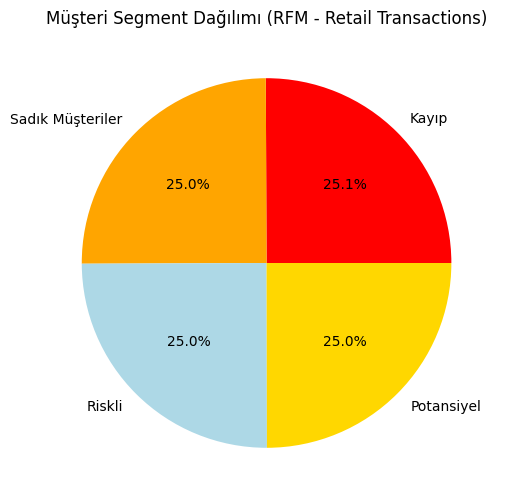

In [34]:
# Hücre 4: Görselleştirme
import matplotlib.pyplot as plt

segment_counts = rfm['Segment'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%', colors=['red', 'orange', 'lightblue', 'gold'])
plt.title('Müşteri Segment Dağılımı (RFM - Retail Transactions)')
plt.show()